<a href="https://colab.research.google.com/github/1kaiser/test2022/blob/main/MLP_Image_Train_Inference_JAX_v0.4.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **RUN** 

### Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

[--xla_force_host_platform_device_count](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html#:~:text=When%20running%20on-,CPU,-you%20can%20always)

In [1]:
#✅
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'
import jax
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

In [2]:
#✅
import jax
import jax.numpy as jnp

positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(inputs):
    print("positional_encoding start")
    batch_size, _ = inputs.shape;print(inputs.shape)
    inputs_freq = jax.vmap(lambda x: inputs * 2.0 ** x)(jnp.arange(positional_encoding_dims));print(inputs_freq.shape)
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)]);print(x.shape)
    x = x.swapaxes(0, 2);print(x.shape)
    x = x.reshape([batch_size, -1]);print(x.shape)
    x = jnp.concatenate([inputs, x], axis=-1);print(x.shape)
    print("positional_encoding end")
    return x



In [3]:
import jax
jax.config.update('jax_array', True)

JAX code >>>

In [4]:
import os

import functools
from typing import Optional

import numpy as np

import jax
import jax.numpy as jnp

jax.config.update('jax_array', True)

In [5]:
if len(jax.local_devices()) < 8:
  raise Exception("Notebook requires 8 devices to run")

In [6]:
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

In [7]:
# Create a Sharding object to distribute a value across devices:
sharding = PositionalSharding(mesh_utils.create_device_mesh((8,)))

In [8]:
!python -m pip install rich #`visualize_sharding` requires `rich` to be installed.
# Create an array of random values:
x = jax.random.normal(jax.random.PRNGKey(0), (8192, 8192))
# and use jax.device_put to distribute it across devices:
y = jax.device_put(x, sharding.reshape(2, 4))
y.shape
type(y)  #jax.debug.visualize_array_sharding(y)
sharding = sharding.reshape(4, 2)
print(sharding)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 237 kB 21.9 MB/s 
     |████████████████████████████████| 51 kB 6.1 MB/s 
PositionalSharding([[{CPU 0} {CPU 1}]
                    [{CPU 2} {CPU 3}]
                    [{CPU 4} {CPU 5}]
                    [{CPU 6} {CPU 7}]])


### MLP MODEL
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [9]:
#✅
!python -m pip install -q -U flax

import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
num_dense_layers = 8 # Number of dense layers in MLP
dense_layer_width = 256 # Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        print("network model start")
        print(x.shape)
        for i in range(num_dense_layers):
            x = nn.Dense(dense_layer_width,dtype=self.dtype,precision=self.precision)(x)
            x = nn.relu(x)
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
            print(x.shape)
  
        x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
        print(x.shape)
        print("network model end")
        return x
##########################################<< MLP MODEL >>#########################################

     |████████████████████████████████| 197 kB 32.2 MB/s 
     |████████████████████████████████| 154 kB 58.8 MB/s 
     |████████████████████████████████| 8.3 MB 45.9 MB/s 
     |████████████████████████████████| 66 kB 4.7 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 


### initialize the module

In [14]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def init_train_state(model, r_key, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    # BATCH, image_height, image_width, cha = shape
    # size = image_height * image_width
    # yt = jnp.ones((size, cha))
    init_variables = model.init(r_key, jnp.ones(shape))  # Initialize the Model
    optimizer = optax.adam(learning_rate) # Create the optimizer
    # Create a State
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=init_variables['params']
    )

learning_rate = 1e-4
batch_size_no = 64

model = MLPModel() # Instantiate the Model

key, rng = jax.random.split(jax.random.PRNGKey(0))
x = jnp.ones(shape=(batch_size_no, 28, 28, 1)) # Dummy Input
_, image_height, image_width, channels = x.shape

state = init_train_state( model, rng, (image_height * image_width, channels), learning_rate )


(784, 1)
positional_encoding start
(784, 1)
(6, 784, 1)
(2, 6, 784, 1)
(784, 6, 2, 1)
(784, 12)
(784, 13)
positional_encoding end
network model start
(784, 13)
(784, 256)
(784, 256)
(784, 256)
(784, 256)
(784, 257)
(784, 256)
(784, 256)
(784, 256)
(784, 1)
network model end


In [15]:
def image_difference_loss(logits, labels):
    loss = .5 * jnp.mean((logits - labels) ** 2)
    return loss
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  loss = lax.pmean(loss, axis_name="batch");print("ok4")
  metrics = {
      'loss': loss,
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

In [34]:
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    print(batch)
    image, label = batch
    print(image,"<<<image")
    print(label,"<<<label")    
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);print("done1",logits.shape)
        loss =  image_difference_loss(logits, label);print("done2",loss.shape)
        return loss, logits

    print("ok1really")
    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True);print("ok1")
    (_, logits), grads = gradient_fn(state.params);print("ok2")
    #train_loss, gradients_each = jax.value_and_grad(loss_fn)(state.params);print("ok3")
    grads = lax.pmean(grads,"batch");print("ok4")
    # grads = jnp.mean(grads);print("ok4")
    state = state.apply_gradients(grads=grads);print("ok5")
    # train_loss = jnp.mean(train_loss);print("ok6")
    logs = compute_metrics(logits=logits, labels=label);print("ok7")
    return state, logs

parallel_train_step = jax.pmap(train_step, "batch")
# parallel_train_step = jax.pmap(train_step, axis_name="batch", in_axes = (0, 0, 0))

import jax
@jax.jit
def eval_step(state, batch):
    image, label = batch
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=label)


### train & evaluation function

In [ ]:
!gdown https://drive.google.com/uc?id=1UgWEotThxnP-Vh-h83-VcTPMkKWmgCDe #downloading MAP-DEM 

In [71]:
!wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg

newsize = (150, 150) # /.... 233 * 454
from PIL import Image
import jax.numpy as jnp

def imageGRAY(argv):
    im = Image.open(argv).convert('L')
    # im = Image.open(argv).convert('L')
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,1)
    return tvt, tvu
def imageRGB(argv):
    im = Image.open(argv)
    tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
    return tvt, tvu


--2022-12-20 20:33:52--  https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.160.38.87, 2600:9000:2015:9a00:0:5a51:64c9:c681, 2600:9000:2015:8800:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.160.38.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘a.jpg’

a.jpg                   [ <=>                ] 230.86K  --.-KB/s    in 0.005s  

2022-12-20 20:33:52 (41.2 MB/s) - ‘a.jpg’ saved [236398]



download [flower dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?resource=download) from kaggle.

In [ ]:
!cp "/content/drive/MyDrive/OUT/data/machine_learning_test_dataset/archive.zip" "/content/"
!unzip /content/archive.zip #unzipping the flower images from archive..

or

In [23]:
!gdown https://drive.google.com/uc?id=1SynswUkxdl6B3c6Uc7Q6MhLG3XirrHd9 # downloading from google drive saved location.. 
!unzip /content/archive.zip #unzipping the flower images from archive..

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1SynswUkxdl6B3c6Uc7Q6MhLG3XirrHd9 

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [26]:
!mkdir -p /content/flowers/all
!cp /content/flowers/daisy/* /content/flowers/all
!cp /content/flowers/dandelion/* /content/flowers/all
!cp /content/flowers/rose/* /content/flowers/all
!cp /content/flowers/sunflower/* /content/flowers/all
!cp /content/flowers/tulip/* /content/flowers/all

In [37]:
# testing batching of the dataset frfom the total dataset, by assuming batch size as 8 then running 50 epochs over the batch , then moving processing onto next batch>>>
batch_size = jax.device_count()    #///// batchsize depending on number of devices available for processing
import os
image_dir = r'/content/flowers/tulip/'
#############################################################################
prefix = "sur_refl_"
bandend = ["c",".jpg", "b02", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.jpg'
expression_b2 = bandend[1]
total_images =  [f for f in os.listdir(image_dir) if f.__contains__(expression_b2)]
total_images.sort()
total_images_path = [os.path.join(image_dir, i) for i in total_images if i != 'outputs']
no_of_batches = int(len(total_images_path)/batch_size)




In [60]:
drive_folder = '/content/drive/MyDrive/OUT/data/machine_learning_test_dataset/DepthMap'


import os
 
# Read images with OpenCV.
#images= None
image_dir = "MEDIAPIPEinput/"
os.makedirs(image_dir, exist_ok=True)
image_dir_out = "annotated_images/"
os.makedirs(image_dir_out, exist_ok=True)

In [59]:
!rm -r /content/MEDIAPIPEinput/input1 /content/annotated_images/outputs_leres

In [61]:
#############################################################################

!cp -r {drive_folder}'/MEDIAPIPEinput' {image_dir}
!cp -r {drive_folder}'/annotated_images' {image_dir_out}
#############################################################################

In [62]:

# testing batching of the dataset frfom the total dataset, by assuming batch size as 8 then running 50 epochs over the batch , then moving processing onto next batch>>>
batch_size = jax.device_count()    #///// batchsize depending on number of devices available for processing
import os
#############################################################################
prefix = "sur_refl_"
bandend = ["c",".png", "b02", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.jpg'
expression_b2 = bandend[1]
image_dir = "MEDIAPIPEinput/MEDIAPIPEinput"
image_dir_out = "annotated_images/annotated_images"

total_images =  [f for f in os.listdir(image_dir) if f.__contains__(expression_b2)]
total_images.sort()
total_images_path = [os.path.join(image_dir, i) for i in total_images if i != 'outputs']
no_of_batches = int(len(total_images_path)/batch_size)
total_images_annotate =  [f for f in os.listdir(image_dir_out) if f.__contains__(expression_b2)]
total_images_annotate.sort()
total_images_annotate_path = [os.path.join(image_dir_out, i) for i in total_images_annotate if i != 'outputs']


In [64]:
len(total_images)
len(total_images_annotate)

343

In [28]:
jax.device_count()

8

### **tensorboard visualization of loss graph**

In [29]:
!rm -r /content/ckpts

rm: cannot remove '/content/ckpts': No such file or directory


In [30]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
logdir = "runs"

writer = SummaryWriter(logdir)

In [35]:
%tensorboard --logdir={logdir}

Reusing TensorBoard on port 6006 (pid 7254), started 0:02:27 ago. (Use '!kill 7254' to kill it.)

<IPython.core.display.Javascript object>

## **RUN 2**

8 19600 3
(19600, 3)
positional_encoding start
(19600, 3)
(6, 19600, 3)
(2, 6, 19600, 3)
(19600, 6, 2, 3)
(19600, 36)
(19600, 39)
positional_encoding end
network model start
(19600, 39)
(19600, 256)
(19600, 256)
(19600, 256)
(19600, 256)
(19600, 259)
(19600, 256)
(19600, 256)
(19600, 256)
(19600, 1)
network model end
0 of total number of batches 42
(Traced<ShapedArray(uint8[19600,3])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(uint8[19600,1])>with<DynamicJaxprTrace(level=0/1)>)
Traced<ShapedArray(uint8[19600,3])>with<DynamicJaxprTrace(level=0/1)> <<<image
Traced<ShapedArray(uint8[19600,1])>with<DynamicJaxprTrace(level=0/1)> <<<label
ok1really
ok1
positional_encoding start
(19600, 3)
(6, 19600, 3)
(2, 6, 19600, 3)
(19600, 6, 2, 3)
(19600, 36)
(19600, 39)
positional_encoding end
network model start
(19600, 39)
(19600, 256)
(19600, 256)
(19600, 256)
(19600, 256)
(19600, 259)
(19600, 256)
(19600, 256)
(19600, 256)
(19600, 1)
network model end
done1 (19600, 1)
done2 ()
ok2
ok4
ok

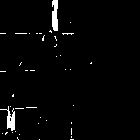

labels shape ⚡⚡⚡⚡ (19600, 1)


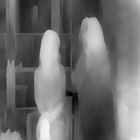

1


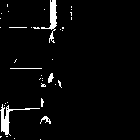

labels shape ⚡⚡⚡⚡ (19600, 1)


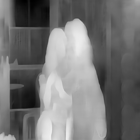

2


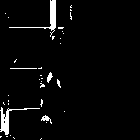

labels shape ⚡⚡⚡⚡ (19600, 1)


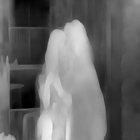

3


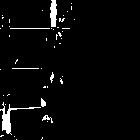

labels shape ⚡⚡⚡⚡ (19600, 1)


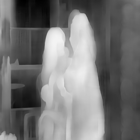

4


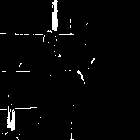

labels shape ⚡⚡⚡⚡ (19600, 1)


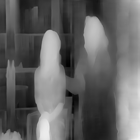

5


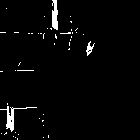

labels shape ⚡⚡⚡⚡ (19600, 1)


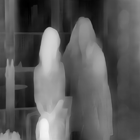

6


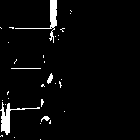

labels shape ⚡⚡⚡⚡ (19600, 1)


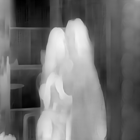

7


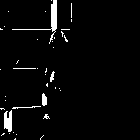

labels shape ⚡⚡⚡⚡ (19600, 1)


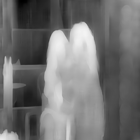

1 of total number of batches 42
<<✅✅✅epoc :  0  complete✅✅✅>>
 7538.017
logits shape ⚡⚡⚡⚡ (19600, 1)
0


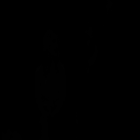

labels shape ⚡⚡⚡⚡ (19600, 1)


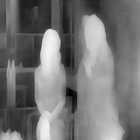

1


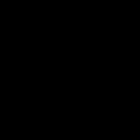

labels shape ⚡⚡⚡⚡ (19600, 1)


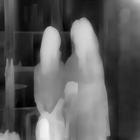

2


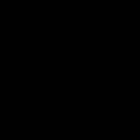

labels shape ⚡⚡⚡⚡ (19600, 1)


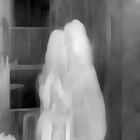

3


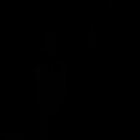

labels shape ⚡⚡⚡⚡ (19600, 1)


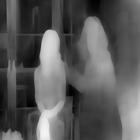

4


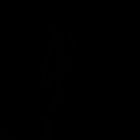

labels shape ⚡⚡⚡⚡ (19600, 1)


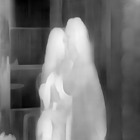

5


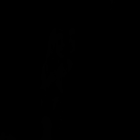

labels shape ⚡⚡⚡⚡ (19600, 1)


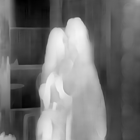

6


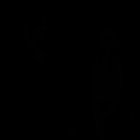

labels shape ⚡⚡⚡⚡ (19600, 1)


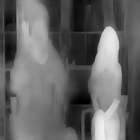

7


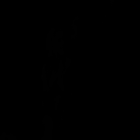

labels shape ⚡⚡⚡⚡ (19600, 1)


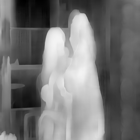

2 of total number of batches 42
<<✅✅✅epoc :  0  complete✅✅✅>>
 6799.9766
logits shape ⚡⚡⚡⚡ (19600, 1)
0


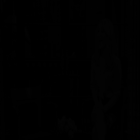

labels shape ⚡⚡⚡⚡ (19600, 1)


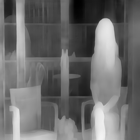

1


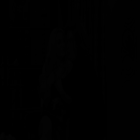

labels shape ⚡⚡⚡⚡ (19600, 1)


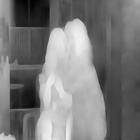

2


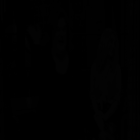

labels shape ⚡⚡⚡⚡ (19600, 1)


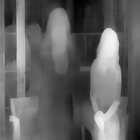

3


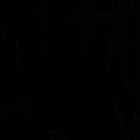

labels shape ⚡⚡⚡⚡ (19600, 1)


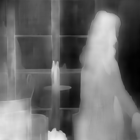

4


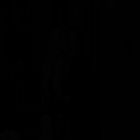

labels shape ⚡⚡⚡⚡ (19600, 1)


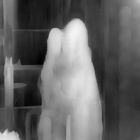

5


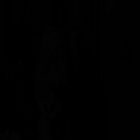

labels shape ⚡⚡⚡⚡ (19600, 1)


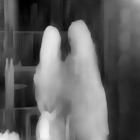

6


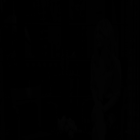

labels shape ⚡⚡⚡⚡ (19600, 1)


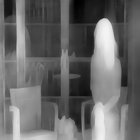

7


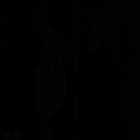

labels shape ⚡⚡⚡⚡ (19600, 1)


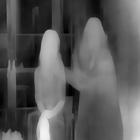

3 of total number of batches 42
<<✅✅✅epoc :  0  complete✅✅✅>>
 7712.8477
logits shape ⚡⚡⚡⚡ (19600, 1)
0


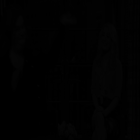

labels shape ⚡⚡⚡⚡ (19600, 1)


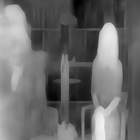

1


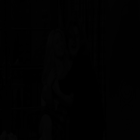

labels shape ⚡⚡⚡⚡ (19600, 1)


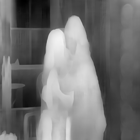

2


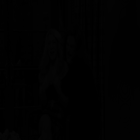

labels shape ⚡⚡⚡⚡ (19600, 1)


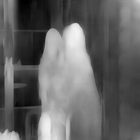

3


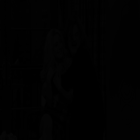

labels shape ⚡⚡⚡⚡ (19600, 1)


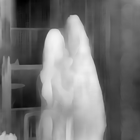

4


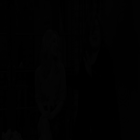

labels shape ⚡⚡⚡⚡ (19600, 1)


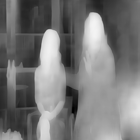

5


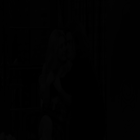

labels shape ⚡⚡⚡⚡ (19600, 1)


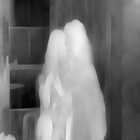

6


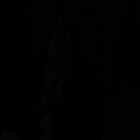

labels shape ⚡⚡⚡⚡ (19600, 1)


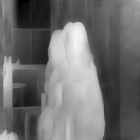

7


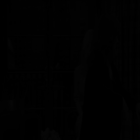

labels shape ⚡⚡⚡⚡ (19600, 1)


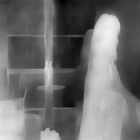

4 of total number of batches 42
<<✅✅✅epoc :  0  complete✅✅✅>>
 7667.7417
logits shape ⚡⚡⚡⚡ (19600, 1)
0


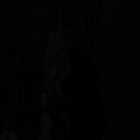

labels shape ⚡⚡⚡⚡ (19600, 1)


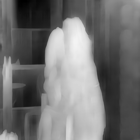

1


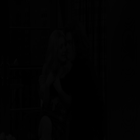

labels shape ⚡⚡⚡⚡ (19600, 1)


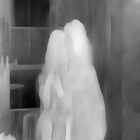

2


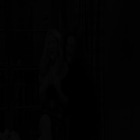

labels shape ⚡⚡⚡⚡ (19600, 1)


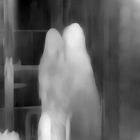

3


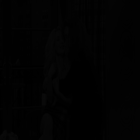

labels shape ⚡⚡⚡⚡ (19600, 1)


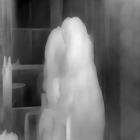

4


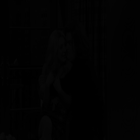

labels shape ⚡⚡⚡⚡ (19600, 1)


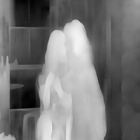

5


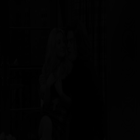

labels shape ⚡⚡⚡⚡ (19600, 1)


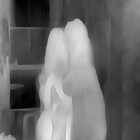

6


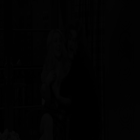

labels shape ⚡⚡⚡⚡ (19600, 1)


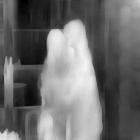

7


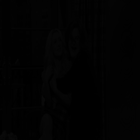

labels shape ⚡⚡⚡⚡ (19600, 1)


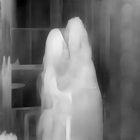

5 of total number of batches 42


In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (140,140) #(260, 260) # /.... 233 * 454

import jax
from jax import random
def batchedimages(image_locations):
  ddyss = jnp.asarray((imageRGB(total_images_path[image_locations[0]])[1],
                      imageRGB(total_images_path[image_locations[1]])[1],
                      imageRGB(total_images_path[image_locations[2]])[1],
                      imageRGB(total_images_path[image_locations[3]])[1],
                      imageRGB(total_images_path[image_locations[4]])[1],
                      imageRGB(total_images_path[image_locations[5]])[1],
                      imageRGB(total_images_path[image_locations[6]])[1],
                      imageRGB(total_images_path[image_locations[7]])[1]))
  ddxss = jnp.asarray((imageGRAY(total_images_annotate_path[image_locations[0]])[1],
                      imageGRAY(total_images_annotate_path[image_locations[1]])[1],
                      imageGRAY(total_images_annotate_path[image_locations[2]])[1],
                      imageGRAY(total_images_annotate_path[image_locations[3]])[1],
                      imageGRAY(total_images_annotate_path[image_locations[4]])[1],
                      imageGRAY(total_images_annotate_path[image_locations[5]])[1],
                      imageGRAY(total_images_annotate_path[image_locations[6]])[1],
                      imageGRAY(total_images_annotate_path[image_locations[7]])[1]))
  #print(ddyss.shape,"<<<< ddyss.shape???",ddxss.shape,"<<<< ddxss.shape???") #to check shape 
  batch_ccc = ddyss, ddxss
  return batch_ccc
  
def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(total_images_path))
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    yield batchedimages(batch_idx)

batches = data_stream()  ### this stream will utilize the array of paths of images to a folder, then "generate" batches into the variable

next(batches)[0].shape ### this command starts initial 8 image  stream, if callled inside a iteration loop then it will get next images for calculations>>>
vv, shapea, channels = next(batches)[0].shape # seitting values >>> [0] 8 784 3  [1] 8 784 1 ; RGB & GRAYSCALE versions 8 images each converted to 1-D array
print(vv, shapea, channels)
######################<<< summary writer for tensor board
# from torch.utils.tensorboard import SummaryWriter
# logdir = "runs"
# writer = SummaryWriter(logdir)
######################
######################
rng = jax.random.PRNGKey(0)
# dropout_rngs = jax.random.split(rng, jax.local_device_count())
######################
#################################<<< checking if checkpoint already available
import os # importing os module
import re # to find file using regular expression
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1
#################################
##########################################<<< loading checkpoint by checking the Flag available
from flax.training import checkpoints
if checkpoint_available:
  CKPT_DIR = 'ckpts'
  restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
  #state = flax.jax_utils.replicate(restored_state)
  print("true <<< File loaded for and replicated to all devices")
##########################################
######################<<<< initiating train state
count = 0
if count == 0 :
  state = init_train_state( model, rng, (shapea, channels), learning_rate ) 
  count = 1
state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy
dropout_rngs = jax.random.split(rng, jax.local_device_count())
######################
from flax.training import checkpoints
import time
total_epochs = 50
for epochs in range(total_epochs):   # EPOCHS for training & updating the initiated state, metrics may show the loss in each epochs or iteration
  start_time = time.time()
  batches = data_stream()  ### this stream will utilize the array of paths of images to a folder, then "generate" batches into the variable
  if checkpoint_available:
    CKPT_DIR = 'ckpts'
    restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    state = restored_state
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r /content/ckpts
  for bbb in range(no_of_batches-5):
    print(bbb,"of total number of batches",no_of_batches)
    state, metrics = parallel_train_step(state, next(batches), dropout_rngs)
    print("<<✅✅✅epoc : ",epochs," complete✅✅✅>>\n",metrics['loss'][0]) #printing loss 1 out of 8 processed in 8 devices
    
    #############################################<<< output visualization 👍🏻
    from google.colab.patches import cv2_imshow
    import numpy as np        # source : https://www.folkstalk.com/tech/how-to-convert-numpy-array-to-cv2-image-with-code-examples/
    
    print("logits shape ⚡⚡⚡⚡", metrics['logits'][0].shape)
    L1 = metrics['logits'][0]
    # predicted_image = np.array(L1,  dtype=np.uint8).reshape(newsize) # This would be your image array
    # cv2img = cv2_imshow(predicted_image) # This work the same as passing an image
    for i in range(0,metrics['labels'].shape[0]):
      print(i)
      predicted_image = np.array(metrics['logits'][i],  dtype=np.uint8).reshape(newsize) # This would be your image array
      cv2_imshow(predicted_image)

      print("labels shape ⚡⚡⚡⚡", metrics['labels'][0].shape)
      L2 = metrics['labels'][0]
      actual_image = np.array(metrics['labels'][i],  dtype=np.uint8).reshape(newsize) # This would be your image array newsize = image_width , image_height
      cv2img = cv2_imshow(actual_image) # This work the same as passing an image
    #############################################<<< output visualization 👍🏻
    

    

    writer.add_scalar('Loss', int(metrics['loss'][0]), epochs)
  epoch_time = time.time() - start_time
  print(f"Epoch {epochs} in {epoch_time:0.2f} sec")
  ##################################################<<< model saving mechanism for flax model state as checkpoints for each epochs,"checkpoint" is a terminology that means all the model weights and biases during the calculation till the completion of 1 epoch were being updated, then this final set of weights and biases including their placement inside the model will be saves as a (schema+weight values) saved as checkpoint in the mentioned <<CKPT_DIR = 'ckpts'>> mentioned folder.  
  CKPT_DIR = 'ckpts'
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step= epochs)     # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
  restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################
  # images = total_images_path[batch_idx]
writer.flush()

In [ ]:
from google.colab.patches import cv2_imshow
import numpy        # source : https://www.folkstalk.com/tech/how-to-convert-numpy-array-to-cv2-image-with-code-examples/
predicted_image = np.array(L1,  dtype=np.uint8).reshape(newsize) # This would be your image array
cv2img = cv2_imshow(predicted_image) # This work the same as passing an image


actual_image = np.array(L2,  dtype=np.uint8).reshape(newsize) # This would be your image array
cv2img = cv2_imshow(actual_image) # This work the same as passing an image



## **RUN 3**

### **SETING UP INFERENCE** 🖼️🥽.

In [ ]:
def batchedimages(image_locations):
  ddyss = jnp.asarray((imageRGB(image_locations)[1],
                      imageRGB(image_locations)[1],
                      imageRGB(image_locations)[1],
                      imageRGB(image_locations)[1],
                      imageRGB(image_locations)[1],
                      imageRGB(image_locations)[1],
                      imageRGB(image_locations)[1],
                      imageRGB(image_locations)[1]))
  ddxss = jnp.asarray((imageGRAY(image_locations)[1],
                      imageGRAY(image_locations)[1],
                      imageGRAY(image_locations)[1],
                      imageGRAY(image_locations)[1],
                      imageGRAY(image_locations)[1],
                      imageGRAY(image_locations)[1],
                      imageGRAY(image_locations)[1],
                      imageGRAY(image_locations)[1]))
  #print(ddyss.shape,"<<<< ddyss.shape???",ddxss.shape,"<<<< ddxss.shape???") #to check shape 
  batch_ccc = ddyss, ddxss
  return batch_ccc

IMAGE_PATHS = "/content/a.jpg"
batches = batchedimages(IMAGE_PATHS)  ### this stream will utilize the array of paths of images to a folder, then "generate" batches into the variable

batches[0].shape ### this command starts initial 8 image  stream, if callled inside a iteration loop then it will get next images for calculations>>>
vv, shapea, channels = batches[0].shape # seitting values >>> [0] 8 784 3  [1] 8 784 1 ; RGB & GRAYSCALE versions 8 images each converted to 1-D array
print(vv, shapea, channels)

##################################################<<< model saving mechanism for flax model state as checkpoints for each epochs,"checkpoint" is a terminology that means all the model weights and biases during the calculation till the completion of 1 epoch were being updated, then this final set of weights and biases including their placement inside the model will be saves as a (schema+weight values) saved as checkpoint in the mentioned <<CKPT_DIR = 'ckpts'>> mentioned folder.  
state = init_train_state( model, rng, (shapea, channels), learning_rate ) 
state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy
dropout_rngs = jax.random.split(rng, jax.local_device_count())

CKPT_DIR = 'ckpts'
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
##################################################

state, metrics = parallel_train_step(restored_state, batches, dropout_rngs)
print("<<Calculations complete✅✅✅ loss: >>",metrics['loss'][0]) #printing loss 1 out of 8 processed in 8 devices

#############################################<<< output visualization 👍🏻
from google.colab.patches import cv2_imshow
import numpy as np       # source : https://www.folkstalk.com/tech/how-to-convert-numpy-array-to-cv2-image-with-code-examples/

print("logits shape ⚡⚡⚡⚡", metrics['logits'][0].shape)
L1 = metrics['logits'][0]
predicted_image = np.array(L1,  dtype=np.uint8).reshape(newsize) # This would be your image array
cv2img = cv2_imshow(predicted_image) # This work the same as passing an image

print("labels shape ⚡⚡⚡⚡", metrics['labels'][0].shape)
L2 = metrics['labels'][0]
actual_image = np.array(L2,  dtype=np.uint8).reshape(newsize) # This would be your image array newsize = image_width , image_height
cv2img = cv2_imshow(actual_image) # This work the same as passing an image
#############################################<<< output visualization 👍🏻


In [ ]:
metrics['labels'].shape[0]
images = []
from google.colab.patches import cv2_imshow
import cv2
for i in range(0,metrics['labels'].shape[0]):
  print(i)
  predicted_image = np.array(metrics['labels'][i], dtype=np.uint8).reshape(newsize) # This would be your image array
  cv2img = cv2_imshow(predicted_image)

#  cv2img = cv2_imshow(predicted_image) # This work the same as passing an image
# cv2img = cv2_imshow(images)
len(images)
print(predicted_image)

### **GeoTiff to Image & Imahe to GeoTiff Conversion**

In [ ]:
!gdown https://drive.google.com/uc?id=1-6Mxg3hroKxXFGBn3y6wIEHK1L6GdgwJ #downloading DEM-MAP https://drive.google.com/file/d/1-6Mxg3hroKxXFGBn3y6wIEHK1L6GdgwJ/view?usp=share_link
%cd /content

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import re

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

def get_gain_band(input_file):
    """get GAIN_BAND from meta file (*.tif.txt)"""
     # define file name of *.tif.txt
    ifile_txt = re.sub(r'.tif', '.tif.txt', input_file)
    ld = open(ifile_txt)
    lines = ld.readlines()
    ld.close()
    
    gain_band = []
    for line in lines:
        if line.find("GAIN_BAND") >= 0:
             gain_band.append(float((re.split(' ', line)[1]).strip()))
    return gain_band

def tif2array(input_file, calc_gain=True):
    """
    read GeoTiff and convert to numpy.ndarray.
    Inputs:
        input_file (str) : the name of input GeoTiff file.
        calc_gain (bool) : wheter calc GAIN to DN  or not (defaul:True).
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive.
    """
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=float)
    
    if calc_gain == True:
        # get gain
        gain = get_gain_band(input_file)
    
    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if calc_gain == True:
            # calc gain value for each bands
            image[:, :, b] = band.ReadAsArray() * gain[b]
        else:
            image[:, :, b] = band.ReadAsArray()
    return image, dataset

def array2raster(newRasterfn, dataset, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # # Loop over all bands.
    # for b in range(band_num):
    #     outband = outRaster.GetRasterBand(b + 1)
    #     # Read in the band's data into the third dimension of our array
    #     if band_num == 1:
    #         outband.WriteArray(array)
    #     else:
    #         outband.WriteArray(array[:,:,b])
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array.reshape(rows, cols))
    # setting srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    return newRasterfn

In [ ]:
INPUT.ndim
INPUT.reshape(INPUT.shape[0],INPUT.shape[1]).shape

In [ ]:
INPUT_PATH = "/content/MOD09A1.061_sur_refl_b01_doy2000065_aid0001.tif"
INPUT,Datasetq = tif2array(INPUT_PATH,0) #<<<<<<<<<<<<<<<<<< input
type(INPUT)
print(INPUT,Datasetq)
len(INPUT)
INPUT[0].shape
dataset = gdal.Open(INPUT_PATH, gdal.GA_ReadOnly)
originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 
print(originX, pixelWidth, b, originY, d, pixelHeight)
print(INPUT.shape)
OUTPUT = array2raster("geo1.tif", Datasetq, INPUT, "Float32") #<<<<<<<<<<<<< output

type(OUTPUT)
OUTPUT

In [ ]:
print(INPUT.shape)
INPUT[0][:,:].shape
from google.colab.patches import cv2_imshow
cv2img = cv2_imshow(OUTPUT)


# image

In [ ]:
newsize = (260, 260) # /.... 233 * 454

import jax
from jax import random
def batchedimages(image_locations):
  ddyss = jnp.asarray((tif2array((total_images_path[image_locations[0]]),0)[1],
                      imageRGB(total_images_path[image_locations[1]])[1],
                      imageRGB(total_images_path[image_locations[2]])[1],
                      imageRGB(total_images_path[image_locations[3]])[1],
                      imageRGB(total_images_path[image_locations[4]])[1],
                      imageRGB(total_images_path[image_locations[5]])[1],
                      imageRGB(total_images_path[image_locations[6]])[1],
                      imageRGB(total_images_path[image_locations[7]])[1]))
  ddxss = jnp.asarray((imageGRAY(total_images_path[image_locations[0]])[1],
                      imageGRAY(total_images_path[image_locations[1]])[1],
                      imageGRAY(total_images_path[image_locations[2]])[1],
                      imageGRAY(total_images_path[image_locations[3]])[1],
                      imageGRAY(total_images_path[image_locations[4]])[1],
                      imageGRAY(total_images_path[image_locations[5]])[1],
                      imageGRAY(total_images_path[image_locations[6]])[1],
                      imageGRAY(total_images_path[image_locations[7]])[1]))
  #print(ddyss.shape,"<<<< ddyss.shape???",ddxss.shape,"<<<< ddxss.shape???") #to check shape 
  batch_ccc = ddyss, ddxss
  return batch_ccc
  
def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(total_images_path))
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    yield batchedimages(batch_idx)

batches = data_stream() 
print(next(batches)[0].shape,next(batches)[1].shape)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **setting up google drive images connection**

In [ ]:
#@title Default title text { vertical-output: true }

image_dir = r'/content/drive/MyDrive/OUT/data/MOD09A1061/files/'

#############################################################################
prefix = "sur_refl_"
bandend = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+bandend[0]
expression_b2 = prefix+bandend[1]
expression_b3 = prefix+bandend[2]
expression_b4 = prefix+bandend[3]
expression_b5 = prefix+bandend[4]
expression_b6 = prefix+bandend[5]
expression_b7 = prefix+bandend[6]

temp_dir = r'/content/'
import os

imgs_list_b2 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b2)] # since the string path item date is same, we just need to change the band number in the string to get other bands, ie. we are doing it by storing image_paths <<< then image_path_b2[i].replace(expression_b2, expression_b4) << to get the b4 band , silimarly bands b1 to b7 image paths can be generated assuming all bands present per image ✅
imgs_list_b2.sort(reverse=True)                     #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....

imgs_path_b2 = [os.path.join(image_dir, i) for i in imgs_list_b2 if i != 'outputs']

print(len(imgs_path_b2))
print(imgs_path_b2[5])

print(imgs_path_b2[5].replace(expression_b2, expression_b4))

batch_size = 8
no_of_batches = int(len(imgs_list_b2)/batch_size)


In [ ]:
print(imgs_list_b2)
len(imgs_list_b2)

In [ ]:
imgs_list_b2[1]
os.path.join(image_dir, imgs_list_b2[1])

In [ ]:
prefix = "sur_refl_"
bandend = ["b01", "b02", "b03", "b04", "b05", "b06", "b07"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+bandend[0]
expression_b2 = prefix+bandend[1]
expression_b3 = prefix+bandend[2]
expression_b4 = prefix+bandend[3]
expression_b5 = prefix+bandend[4]
expression_b6 = prefix+bandend[5]
expression_b7 = prefix+bandend[6]

In [ ]:
len(bandend)
for i in bandend:
  print(i)

merging bands into 1 file ie (width, height, 7 bands) <<< file

In [ ]:
image_dir = r'/content/drive/MyDrive/OUT/data/MOD09A1061/files/'
path = os.path.join(image_dir, imgs_list_b2[1])
v1 = tif2array(path.replace(expression_b2, expression_b1),0)[0]
v2 = jax.numpy.append(v1, tif2array(path.replace(expression_b2, expression_b2),0)[0] , axis =2)
v3 = jax.numpy.append(v2, tif2array(path.replace(expression_b2, expression_b3),0)[0] , axis =2)
v4 = jax.numpy.append(v3, tif2array(path.replace(expression_b2, expression_b4),0)[0] , axis =2)
v5 = jax.numpy.append(v4, tif2array(path.replace(expression_b2, expression_b5),0)[0] , axis =2)
v6 = jax.numpy.append(v5, tif2array(path.replace(expression_b2, expression_b6),0)[0] , axis =2)
v7 = jax.numpy.append(v6, tif2array(path.replace(expression_b2, expression_b7),0)[0] , axis =2)
print(v1.shape,v2.shape,v7.shape)
type(v2)

In [ ]:
v8 = v7.reshape(v7.shape[0]*v7.shape[1], v7.shape[2]).shape
v8

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np     
predicted_image = np.array(v7[:,:,2],  dtype=np.float32) # This would be your image array
cv2img = cv2_imshow(predicted_image) # This work the same as passing an image

clipping into parts 

In [ ]:
import os, sys
from osgeo import gdal

dset = gdal.Open(path)

width = dset.RasterXSize
height = dset.RasterYSize

print(width, 'x', height)

tilesize = 200

for i in range(0, width, tilesize):
    for j in range(0, height, tilesize):
        w = min(i+tilesize, width) - i
        h = min(j+tilesize, height) - j
        gdaltranString = "gdal_translate -of GTIFF -srcwin "+str(i)+", "+str(j)+", "+str(w)+", " \
            +str(h)+" " + path + " " + "/content/" + "_"+str(i)+"_"+str(j)+".tif"
        os.system(gdaltranString)

In [ ]:
c1 = tif2array("/content/_200_200.tif",0)[0]
predicted_image = np.array(c1,  dtype=np.float32) # This would be your image array
cv2img = cv2_imshow(predicted_image)

testing  clip centre location >> 

In [ ]:
shape =[454, 233]
clip_s = [200, 200]
list = []
col = int(shape[0]/clip_s[0])+1
row = int(shape[1]/clip_s[1])+1
in_col = int(((shape[0]-clip_s[0]/2)-(clip_s[0]/2))/(col -1))+1
in_row = int(((shape[1]-clip_s[1]/2)-(clip_s[1]/2))/(col -1))+1
import numpy as np
import matplotlib.pyplot as plt

x = []
y = []
f = plt.figure()
f.set_figwidth(shape[0]/50)
f.set_figheight(shape[1]/50)
plt.plot(x, y)
import matplotlib.patches as patches
ax = plt.gca()
for i in range(0, col):
  for j in range(0, row):
    if(i==0):
      x.append(int(clip_s[0]/2 ))
      y.append(int(j*in_row + clip_s[1]/2 ))
    if(i==col-1):
      x.append(int(i*in_col + clip_s[0]/2 ))
    if(j==0):
      y.append(int(j*in_row + clip_s[1]/2 ))
    if(j==row-1):
      y.append(int(j*in_row + clip_s[1]/2 ))
    else:
      x.append(int(i*in_col + clip_s[0]/2 ))
      y.append(int(j*in_row + clip_s[1]/2 ))
    print(x, y)
    rect = patches.Rectangle((x[i]-clip_s[0]/2, y[j]-clip_s[1]/2), clip_s[0], clip_s[1], linewidth=1, edgecolor='r', facecolor='none')
    print((x[i]-clip_s[0]/2, y[j]-clip_s[1]/2))
    ax.add_patch(rect)
plt.plot(x, y)

# Create a Rectangle patch


# Add the patch to the Axes
# plt.grid()


plt.show()